# Train model to generate contributing statements for a given document

In [20]:
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
import pandas as pd
import numpy as np
from transformers import TrainingArguments, Trainer
from datasets import load_metric
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import os
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence, pad_packed_sequence
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from models import LSTMNet
from constants import *

In [2]:
data_df = pd.read_csv(os.path.join(BASE_DIR, 'generated_data', 'data.csv'))
data_df.head()

,doc_num,sentence,target,doc_path,abstract
0,0,"The reading comprehension task , that asks que...",0,/Users/rohantondulkar/Projects/Typeset/trial-d...,"The reading comprehension task , that asks que..."
1,0,Recent formulations of this task have typicall...,1,/Users/rohantondulkar/Projects/Typeset/trial-d...,"The reading comprehension task , that asks que..."
2,0,"However , Rajpurkar et al . ( 2016 ) recently ...",0,/Users/rohantondulkar/Projects/Typeset/trial-d...,"The reading comprehension task , that asks que..."
3,0,"In this paper , we focus on this answer extrac...",1,/Users/rohantondulkar/Projects/Typeset/trial-d...,"The reading comprehension task , that asks que..."
4,0,We show that scoring explicit span representat...,0,/Users/rohantondulkar/Projects/Typeset/trial-d...,"The reading comprehension task , that asks que..."


## Split extracted data in training and validation. Data adjustments to make it ready for pytorch Dataset

In [3]:
doc_nums = list(data_df['doc_num'].unique())
train_doc_nums, val_doc_nums = train_test_split(doc_nums, test_size=0.2)
train_df = data_df[data_df['doc_num'].isin(train_doc_nums)].reset_index(drop=True)
train_doc_num_map = {}
for i in range(len(train_doc_nums)):
    train_doc_num_map[train_doc_nums[i]] = i
train_df['doc_num'] = train_df['doc_num'].apply(lambda x: train_doc_num_map[x])

val_df = data_df[data_df['doc_num'].isin(val_doc_nums)].reset_index(drop=True)
val_doc_num_map = {}
for i in range(len(val_doc_nums)):
    val_doc_num_map[val_doc_nums[i]] = i
val_df['doc_num'] = val_df['doc_num'].apply(lambda x: val_doc_num_map[x])

train_df.head()

,doc_num,sentence,target,doc_path,abstract
0,6,"The reading comprehension task , that asks que...",0,/Users/rohantondulkar/Projects/Typeset/trial-d...,"The reading comprehension task , that asks que..."
1,6,Recent formulations of this task have typicall...,1,/Users/rohantondulkar/Projects/Typeset/trial-d...,"The reading comprehension task , that asks que..."
2,6,"However , Rajpurkar et al . ( 2016 ) recently ...",0,/Users/rohantondulkar/Projects/Typeset/trial-d...,"The reading comprehension task , that asks que..."
3,6,"In this paper , we focus on this answer extrac...",1,/Users/rohantondulkar/Projects/Typeset/trial-d...,"The reading comprehension task , that asks que..."
4,6,We show that scoring explicit span representat...,0,/Users/rohantondulkar/Projects/Typeset/trial-d...,"The reading comprehension task , that asks que..."


## Use sentence tranformers to generate embeddings for sentences using Sentence Bert i.e. SBert

In [4]:
sentence_transformer_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
train_embeddings = sentence_transformer_model.encode(train_df['sentence'].to_list())
val_embeddings = sentence_transformer_model.encode(val_df['sentence'].to_list())

## Dataset, collate function, DataLoader and hyperparameters setup to train LSTM model on sentence embeddings

In [5]:
class DocumentSentences(Dataset):
    
    def __init__(self, embeddings, data_df):
        self.embeddings = embeddings
        self.data_df = data_df
        
    def __len__(self):
        return self.data_df['doc_num'].unique().shape[0]
        
    def __getitem__(self, idx):
        doc_df = self.data_df[self.data_df['doc_num']==idx]
        targets = doc_df['target'].to_list()
        targets = torch.LongTensor(targets)
        embeddings = self.embeddings[doc_df.index.to_list()]
        embeddings = torch.FloatTensor(embeddings)
        return embeddings, targets, len(targets), idx

In [6]:
train_dataset = DocumentSentences(train_embeddings, train_df)
val_dataset = DocumentSentences(val_embeddings, val_df)

In [7]:
def collate_fn(data):
    embeddings, labels, lengths, idx = zip(*data)
    max_len = max(lengths)
    n_ftrs = data[0][0].size(1)
    features = torch.zeros((len(data), max_len, n_ftrs))
    lengths = torch.tensor(lengths)
    targets = torch.zeros((len(data), max_len))
    for i in range(len(data)):
        j = data[i][1].size(0)
        targets[i] = torch.cat([data[i][1], torch.zeros(max_len-j)])

    for i in range(len(data)):
        j, k = data[i][0].size(0), data[i][0].size(1)
        features[i] = torch.cat([data[i][0], torch.zeros((max_len - j, k))])
    return features.float(), targets, lengths, idx

In [8]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=2, collate_fn=collate_fn)

In [21]:
lstm_net = LSTMNet(EMBEDDING_SIZE, HIDDEN_SIZE)
criterion = nn.BCELoss(reduction='none')
optimizer = torch.optim.Adagrad(lstm_net.parameters(), lr=0.01)

In [22]:
def plot_confusion_matrix(predicted, labels):
    from sklearn.datasets import make_classification
    from sklearn.metrics import ConfusionMatrixDisplay
    ConfusionMatrixDisplay.from_predictions(labels, predicted)


In [23]:
def eval(loader, plot_cm=False):
    running_loss = 0
    num_batches = 0
    total = 0
    all_predicted = []
    all_labels = []
    output_dict = {}
    for i, data in enumerate(loader, 0):
        inputs, labels, lengths, idx = data
        inputs = Variable(inputs)
        labels = Variable(labels)

        h_0 = Variable(torch.zeros(1, inputs.shape[0], HIDDEN_SIZE))
        c_0 = Variable(torch.zeros(1, inputs.shape[0], HIDDEN_SIZE))
        packed_input = pack_padded_sequence(inputs, lengths.cpu().numpy(), batch_first=True, enforce_sorted=False)
        outputs = lstm_net(packed_input, h_0, c_0)
        outputs = torch.squeeze(outputs)
        
        predicted = (outputs > THRESHOLD).int()
        total += labels.size(0)
        for i in range(labels.size(0)):
            all_predicted.extend(predicted[i][:lengths[i]].tolist())
            all_labels.extend(labels[i][:lengths[i]].tolist())
            output_dict[idx[i]] = predicted[i][:lengths[i]]
        loss = criterion(outputs, labels)
        weights = labels.clone()
        weights[labels==0] = WEIGHTS_0
        weights[labels==1] = WEIGHTS_1
        loss = torch.mean(weights*loss)

        running_loss += loss.item()
        num_batches += 1
    f1_scr = f1_score(all_labels, all_predicted)
    accuracy = accuracy_score(all_labels, all_predicted)
    if plot_cm:
        plot_confusion_matrix(all_predicted, all_labels)
    return running_loss/num_batches, accuracy, f1_scr, output_dict

#### Main training method

In [24]:
losses = []
train_f1_scores = []
val_losses = []
val_f1_scores = []
for epoch in range(EPOCHS):
    running_loss = 0.0
    all_predicted = []
    all_labels = []
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs
        inputs, labels, lengths, idx = data
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        packed_input = pack_padded_sequence(inputs, lengths.cpu().numpy(), batch_first=True, enforce_sorted=False)

        # forward + backward + optimize
        h_0 = Variable(torch.zeros(1, inputs.shape[0], HIDDEN_SIZE))
        c_0 = Variable(torch.zeros(1, inputs.shape[0], HIDDEN_SIZE))
        outputs = lstm_net(packed_input, h_0, c_0)
        outputs = torch.squeeze(outputs)
        loss = criterion(outputs, labels)
        weights = labels.clone()
        weights[labels==0] = WEIGHTS_0
        weights[labels==1] = WEIGHTS_1
        loss = torch.mean(weights*loss)
        loss.backward()
        optimizer.step()
        predicted = (outputs > THRESHOLD).int()
        labels=labels.long()
        for i in range(labels.size(0)):
            all_predicted.extend(predicted[i][:lengths[i]].tolist())
            all_labels.extend(labels[i][:lengths[i]].tolist())
        running_loss += loss.item()
        
        # print statistics
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 10))
            losses.append(running_loss / 10)
            running_loss = 0.0
            
    f1_scr = f1_score(all_labels, all_predicted)
    train_f1_scores.append(f1_scr)
    accuracy = accuracy_score(all_labels, all_predicted)
    print('Training metrics at epoch {0}. Acc: {1}, F1 score: {2}'.format(epoch+1, accuracy, f1_scr))  
    val_loss, val_acc, val_f1_scr, _ = eval(val_dataloader)
    val_losses.append(val_loss)
    val_f1_scores.append(val_f1_scr)
    print('Val loss: {0}, Val accuracy: {1}, Val F1 score: {2}'.format(val_loss, val_acc, val_f1_scr))
            
print('Finished Training')



Training metrics at epoch 1. Acc: 0.860046378393125, F1 score: 0.0984182776801406
Val loss: 0.09562489837408066, Val accuracy: 0.9215575620767494, Val F1 score: 0.014184397163120567
Training metrics at epoch 2. Acc: 0.8751875596780794, F1 score: 0.13270142180094788
Val loss: 0.09373789429664611, Val accuracy: 0.9221218961625283, Val F1 score: 0.08
Training metrics at epoch 3. Acc: 0.840812985950075, F1 score: 0.18448637316561847
Val loss: 0.09260396510362626, Val accuracy: 0.8803611738148984, Val F1 score: 0.18461538461538463
Training metrics at epoch 4. Acc: 0.8297640158232165, F1 score: 0.2544802867383512
Val loss: 0.09294414222240448, Val accuracy: 0.7579006772009029, Val F1 score: 0.192090395480226
Training metrics at epoch 5. Acc: 0.8174873823489293, F1 score: 0.23367697594501718
Val loss: 0.09524733871221543, Val accuracy: 0.7223476297968398, Val F1 score: 0.17449664429530204
Training metrics at epoch 6. Acc: 0.8095757741099441, F1 score: 0.2848360655737705
Val loss: 0.0925765529

In [13]:
#torch.save(lstm_net,  os.path.join(BASE_DIR, 'models', 'trained_model.pt'))

#### Plot basic graphs post training

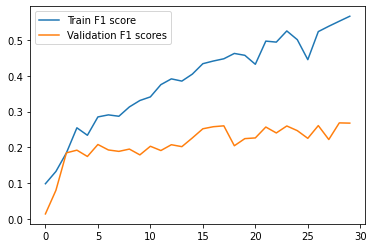

In [25]:
plt.plot(list(range(EPOCHS)), train_f1_scores, label = "Train F1 score")
plt.plot(list(range(EPOCHS)), val_f1_scores, label = "Validation F1 scores")
plt.legend()
plt.show()

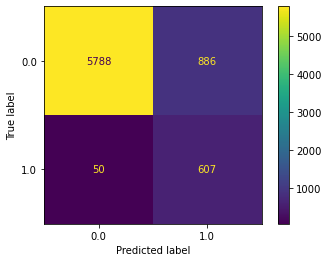

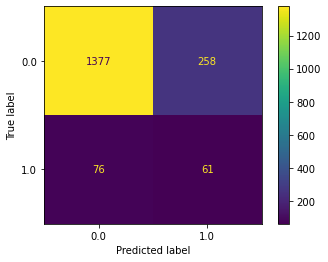

In [28]:
_,_,_,train_output_dict  = eval(train_dataloader, plot_cm=True)
_,_,_,val_output_dict = eval(val_dataloader, plot_cm=True)

### Map and store predictions for every sentence in train and validation

In [29]:
train_df['predicted'] = 999
for doc_num, predicted in train_output_dict.items():
    train_df.loc[train_df['doc_num']==doc_num, 'predicted'] = predicted.tolist()
    
val_df['predicted'] = 999
for doc_num, predicted in val_output_dict.items():
    val_df.loc[val_df['doc_num']==doc_num, 'predicted'] = predicted.tolist()

In [30]:
train_df.to_csv(os.path.join(BASE_DIR, 'generated_data', 'train_df_predicted.csv'), index=False)
val_df.to_csv(os.path.join(BASE_DIR, 'generated_data', 'val_df_predicted.csv'), index=False)